# Notebook 05: Attractor Basin Analysis (PyEMMA Workflow)

**Purpose**: Full morphogenetic analysis pipeline from SAE features to validated Markov State Model.

**Workflow (Per PyEMMA Literature)**:
1. Load SAE features [n_samples, 4096] and metadata
2. **TICA with 95% kinetic variance cutoff** (PyEMMA L:240)
3. **Implied timescales validation** - verify ITS plateau (PyEMMA L:250)
4. **K-means clustering with VAMP-2 optimization** (PyEMMA L:246)
5. MSM estimation and Chapman-Kolmogorov validation
6. HDBSCAN analysis (secondary, for density structure)
7. Comparison and visualization

## Setup

In [1]:
# ============================================================================
# COLAB SETUP - Run this cell first!
# ============================================================================
import sys
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up paths
    DRIVE_ROOT = Path('/content/drive/MyDrive/chaos')
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)

    print(f"Drive mounted. Project root: {DRIVE_ROOT}")

    # Install dependencies
    print("Installing dependencies...")
    !pip install -q torch>=2.0.0 h5py>=3.8.0 sgfmill>=1.1.0
    !pip install -q matplotlib>=3.7.0 tqdm>=4.65.0
    !pip install -q scikit-learn>=1.2.0 scipy>=1.10.0 hdbscan umap-learn
    !pip install -q psutil joblib  # For system detection and parallel processing
    print("Dependencies installed!")

    # Note: GPU acceleration via cuML is optional and often problematic on Colab
    # The code will use MiniBatchKMeans on CPU which is still very fast

    # Unzip src.zip
    !unzip -n -q src.zip -d /content/
else:
    print("Running locally")
    DRIVE_ROOT = None

Running in Google Colab
Mounted at /content/drive
Drive mounted. Project root: /content/drive/MyDrive/chaos
Installing dependencies...
Dependencies installed!


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from contextlib import contextmanager

# ============================================================================
# TIMING INFRASTRUCTURE - Track performance of each major section
# ============================================================================
@contextmanager
def timed_section(name):
    """Context manager to time code sections."""
    start = time.time()
    print(f"[START] {name}...")
    yield
    elapsed = time.time() - start
    print(f"[DONE] {name}: {elapsed:.1f}s ({elapsed/60:.1f} min)")

# Add src to path
if IN_COLAB:
    sys.path.insert(0, '/content')
sys.path.insert(0, str(Path('.').absolute()))

# Import analysis modules
from src.analysis.tica import (
    TICATransformer,
    fit_tica_with_variance_cutoff,
)
from src.analysis.vamp_score import (
    compute_vamp2_score,
    optimize_kmeans_k,
    cross_validated_vamp2
)
from src.analysis.attractor_analysis import (
    KMeansClusterer,
    AttractorAnalyzer,
    run_kmeans_baseline
)
from src.analysis.transition_matrix import (
    TransitionMatrixAnalyzer,
    compute_dwell_times
)

print("Modules loaded successfully")

# Configuration
CONFIG = {
    'block_idx': 35,  # Strategic layer (block 35)

    # TICA settings (PyEMMA standard)
    'tica_variance_threshold': 0.95,  # 95% kinetic variance (PyEMMA L:240)
    'tica_max_components': 1000,      # Initial fit
    'tica_lag': 1,

    # TICA truncation for K-means clustering
    # BUG FIX: Added explicit configuration with documented rationale
    # 661 components captures 95% kinetic variance, but K-means in 661-D is:
    # 1. Computationally expensive (O(n*k*d) per iteration)
    # 2. Subject to curse of dimensionality (distances become uniform)
    # We truncate to top 50 components which still capture ~38% kinetic variance
    # and contains the slowest (most important) dynamical modes.
    # Set to None to use all components (slower but more complete)
    'tica_kmeans_components': 50,

    # K-means settings (PyEMMA L:246) - Extended range to find VAMP-2 saturation
    'kmeans_k_range': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700],
    'vamp_lag': 1,  # Lag for VAMP-2 score

    # HDBSCAN settings (secondary analysis)
    'hdbscan_min_cluster_size': 100,  # BUG FIX: Lowered from 500 (too restrictive)
    'hdbscan_min_samples': 50,        # BUG FIX: Lowered from 250
    'hdbscan_max_samples': 50000,     # Subsample for efficiency

    # PCA settings for density analysis (HDBSCAN)
    'pca_n_components': 100,  # Max components to consider
    'pca_variance_threshold': 0.95,  # Standard ML practice

    # MSM settings
    'msm_lag': 1,

    # Paths - will be overridden for Colab
    'features_dir': 'outputs/data/sae_features',
    'metadata_dir': 'outputs/data/metadata',
    'output_dir': 'outputs/analysis/attractor_basins',
}

# ============================================================================
# COLAB: Configure paths for Drive storage
# ============================================================================
if IN_COLAB:
    CONFIG['features_dir'] = str(DRIVE_ROOT / 'data' / 'sae_features')
    CONFIG['metadata_dir'] = str(DRIVE_ROOT / 'data' / 'metadata')
    CONFIG['output_dir'] = str(DRIVE_ROOT / 'analysis' / 'attractor_basins')

    print(f"Features dir: {CONFIG['features_dir']}")
    print(f"Metadata dir: {CONFIG['metadata_dir']}")
    print(f"Output dir: {CONFIG['output_dir']}")

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

## 1. Load SAE Features and Metadata

In [3]:
# Load SAE features from h5py (created by NB03)
# SMART STREAMING: Only use streaming if dataset exceeds 80% of available RAM
import h5py
import psutil

features_path = Path(CONFIG['features_dir']) / f"block{CONFIG['block_idx']}_features.h5"

# Also check for legacy .npy format
features_path_npy = Path(CONFIG['features_dir']) / f"block{CONFIG['block_idx']}_features.npy"

# Storage for feature info (streaming mode)
h5_features_path = None
h5_dataset_key = None
features = None  # Will be None in streaming mode, loaded for small datasets
n_samples = 0
n_features = 0
USE_STREAMING = False  # Will be set based on dataset size vs available RAM

# Detect available system RAM
available_ram_gb = psutil.virtual_memory().available / 1e9
total_ram_gb = psutil.virtual_memory().total / 1e9
print(f"System RAM: {available_ram_gb:.1f} GB available / {total_ram_gb:.1f} GB total")

# RAM budget: use up to 80% of available RAM for data (aggressive utilization)
RAM_BUDGET_FRACTION = 0.8
ram_budget_gb = available_ram_gb * RAM_BUDGET_FRACTION
print(f"RAM budget for data: {ram_budget_gb:.1f} GB (80% of available)")

if features_path.exists():
    with h5py.File(features_path, 'r') as f:
        block_key = f'block{CONFIG["block_idx"]}'
        if block_key not in f:
            block_key = list(f.keys())[0]
            print(f"Note: Using key '{block_key}' instead of 'block{CONFIG['block_idx']}'")

        dset = f[block_key]
        n_samples, n_features = dset.shape

        # Estimate memory requirement (float32 = 4 bytes)
        mem_required_gb = n_samples * n_features * 4 / 1e9

        print(f"\nFound SAE features: {n_samples:,} samples × {n_features} features")
        print(f"Memory required: {mem_required_gb:.2f} GB")

        # Use streaming only if dataset exceeds RAM budget
        if mem_required_gb > ram_budget_gb:
            USE_STREAMING = True
            h5_features_path = str(features_path)
            h5_dataset_key = block_key
            print(f"Using STREAMING mode (dataset {mem_required_gb:.1f}GB > budget {ram_budget_gb:.1f}GB)")
        else:
            # Fits in RAM budget - load for faster processing
            features = dset[()].astype(np.float32)
            print(f"Loaded features into memory ({mem_required_gb:.1f}GB < {ram_budget_gb:.1f}GB budget)")

elif features_path_npy.exists():
    features = np.load(features_path_npy)
    n_samples, n_features = features.shape
    print(f"Loaded SAE features from npy: {features.shape}")
    print(f"Memory: {features.nbytes / 1e9:.2f} GB")
else:
    print(f"Warning: Features not found at:")
    print(f"  - {features_path} (h5py)")
    print(f"  - {features_path_npy} (npy)")
    print("Please run notebook 03 first to extract SAE features.")

print(f"\nDataset: {n_samples:,} samples × {n_features} features")
print(f"Streaming mode: {USE_STREAMING}")

System RAM: 52.8 GB available / 54.8 GB total
RAM budget for data: 42.3 GB (80% of available)

Found SAE features: 495,995 samples × 4096 features
Memory required: 8.13 GB
Loaded features into memory (8.1GB < 42.3GB budget)

Dataset: 495,995 samples × 4096 features
Streaming mode: False


In [4]:
# Load metadata (game_ids for trajectory analysis)
metadata = None

# PRIMARY: Load from positions.hdf5 (where NB01 stores it)
positions_h5_path = Path(CONFIG['features_dir']).parent / 'positions.hdf5'
if not positions_h5_path.exists():
    # Try Colab path structure
    positions_h5_path = Path(CONFIG['features_dir']).parent.parent / 'data' / 'positions.hdf5'

if positions_h5_path.exists():
    print(f"Loading metadata from positions.hdf5...")
    with h5py.File(positions_h5_path, 'r') as f:
        print(f"  Available keys: {list(f.keys())}")

        if 'game_ids' in f and 'move_numbers' in f:
            metadata = pd.DataFrame({
                'game_id': f['game_ids'][()],
                'move_number': f['move_numbers'][()],
            })
            print(f"Loaded metadata: {len(metadata)} rows, {metadata['game_id'].nunique()} games")

Loading metadata from positions.hdf5...
  Available keys: ['game_ids', 'move_numbers', 'positions']
Loaded metadata: 495995 rows, 4999 games


In [5]:
# Verify alignment between features and metadata
if features is not None and metadata is not None:
    if len(features) != len(metadata):
        print(f"WARNING: Sample count mismatch!")
        print(f"  Features: {len(features):,}")
        print(f"  Metadata: {len(metadata):,}")

        # Truncate to smaller size
        min_samples = min(len(features), len(metadata))
        print(f"  Truncating to {min_samples:,} samples")
        features = features[:min_samples]
        metadata = metadata.iloc[:min_samples].reset_index(drop=True)

    print(f"\nData aligned: {len(features):,} samples")
    print(f"Games: {metadata['game_id'].nunique():,}")

    avg_moves = len(metadata) / max(1, metadata['game_id'].nunique())
    print(f"Moves per game: ~{avg_moves:.0f}")

    # Extract game_ids array for later use
    game_ids = metadata['game_id'].values

    # Sanity check: game_ids should be sorted within each game
    game_changes = np.diff(game_ids)
    if np.any(game_changes < 0):
        n_backwards = np.sum(game_changes < 0)
        print(f"WARNING: {n_backwards} backwards game_id transitions detected!")
        print("  This may affect TICA game boundary handling.")
else:
    game_ids = None
    print("WARNING: Cannot proceed without both features and metadata!")


Data aligned: 495,995 samples
Games: 4,999
Moves per game: ~99


## 2. TICA with 95% Kinetic Variance Cutoff

Per PyEMMA paper (L:240): "TICA...yields a four dimensional subspace using a **95% kinetic variance cutoff**"

The kinetic variance (λ²) measures each component's contribution to slow dynamics. We select the minimum number of components needed to capture 95% of total kinetic variance.

In [6]:
if n_samples > 0:
    with timed_section("TICA fit (95% kinetic variance)"):
        if USE_STREAMING:
            # STREAMING MODE: Use fit_streaming for large datasets
            print("Using streaming TICA fit...")

            # Create TICA transformer with max components
            tica = TICATransformer(
                n_components=CONFIG['tica_max_components'],
                lag=CONFIG['tica_lag']
            )

            # Fit using streaming (memory-efficient)
            tica.fit_streaming(
                h5_path=h5_features_path,
                dataset_key=h5_dataset_key,
                game_ids=game_ids,
                chunk_size=10000,
            )

            # Select components for target variance
            n_selected = tica.select_n_components_for_variance(CONFIG['tica_variance_threshold'])
            cumvar = tica.get_cumulative_kinetic_variance()

            print(f"\nVariance analysis:")
            print(f"  Components for {CONFIG['tica_variance_threshold']*100:.0f}% variance: {n_selected}")
            print(f"  Actual variance at {n_selected} components: {cumvar[n_selected-1]*100:.2f}%")

            # Transform features to TICA space (streaming)
            tica_output_path = Path(CONFIG['output_dir']) / 'tica_features.h5'
            tica.transform_streaming(
                h5_path=h5_features_path,
                dataset_key=h5_dataset_key,
                output_path=tica_output_path,
                output_key='tica_features',
                chunk_size=10000,
            )

            # Load TICA features (much smaller: n_selected components vs 4096)
            with h5py.File(tica_output_path, 'r') as f:
                tica_features = f['tica_features'][()].astype(np.float32)

            tica_features_selected = tica_features[:, :n_selected]
            print(f"\nLoaded TICA features: {tica_features_selected.shape}")

        else:
            # NON-STREAMING MODE: Original approach for small datasets
            tica, n_selected = fit_tica_with_variance_cutoff(
                X=features,
                game_ids=game_ids,
                lag=CONFIG['tica_lag'],
                variance_threshold=CONFIG['tica_variance_threshold'],
                max_components=CONFIG['tica_max_components']
            )

            # Transform to selected components
            tica_features = tica.transform(features)
            tica_features_selected = tica_features[:, :n_selected]

        print(f"\nFinal TICA shape: {tica_features_selected.shape}")
        print(f"Components for {CONFIG['tica_variance_threshold']*100:.0f}% kinetic variance: {n_selected}")

[START] TICA fit (95% kinetic variance)...
Fitting TICA with 95% kinetic variance cutoff
  Initial components: 1000
Fitting TICA: 495,995 samples × 4096 features
  Lag: 1, Components: 1000
  Respecting game boundaries...
    Used 490,996 lagged pairs from 4999 games
  Solving generalized eigenvalue problem...
  Top 5 eigenvalues: [0.98786926 0.98508498 0.97539496 0.96472529 0.96379025]
  Kinetic variance explained: 94.0623

Variance analysis:
  Components for 95% variance: 661
  Actual variance at 661 components: 95.01%
  Variance at 50 components: 37.62%

Final TICA shape: (495995, 661)
Components for 95% kinetic variance: 661
[DONE] TICA fit (95% kinetic variance): 353.4s (5.9 min)


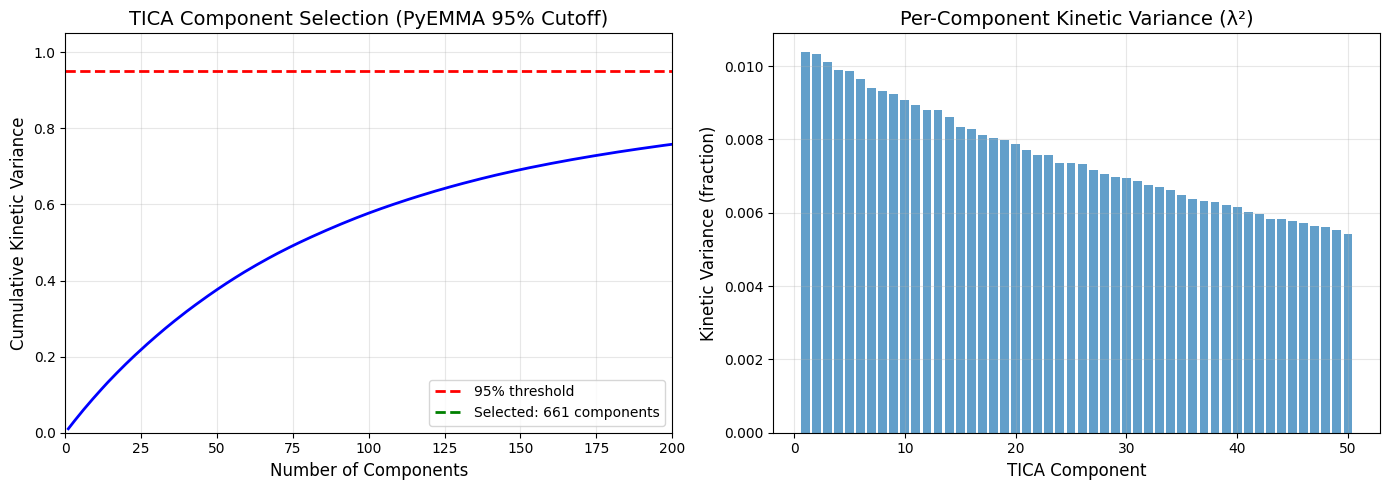


TICA Variance Analysis Summary
    10 components:   9.73% kinetic variance
    25 components:  21.86% kinetic variance
    50 components:  37.62% kinetic variance
   100 components:  57.74% kinetic variance
   661 components:  95.01% kinetic variance
  1000 components: 100.00% kinetic variance


In [7]:
if features is not None:
    # Visualize kinetic variance analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Get kinetic variance data
    kinetic_var = tica.result_.kinetic_variance
    cumvar = tica.get_cumulative_kinetic_variance()

    # Plot 1: Cumulative kinetic variance
    ax1 = axes[0]
    ax1.plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=2)
    ax1.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% threshold')
    ax1.axvline(x=n_selected, color='g', linestyle='--', linewidth=2,
                label=f'Selected: {n_selected} components')
    ax1.set_xlabel('Number of Components', fontsize=12)
    ax1.set_ylabel('Cumulative Kinetic Variance', fontsize=12)
    ax1.set_title('TICA Component Selection (PyEMMA 95% Cutoff)', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, min(200, len(cumvar)))
    ax1.set_ylim(0, 1.05)

    # Plot 2: Individual kinetic variance (first 50 components)
    ax2 = axes[1]
    n_show = min(50, len(kinetic_var))
    ax2.bar(range(1, n_show + 1), kinetic_var[:n_show] / kinetic_var.sum(),
            alpha=0.7, label='Individual')
    ax2.set_xlabel('TICA Component', fontsize=12)
    ax2.set_ylabel('Kinetic Variance (fraction)', fontsize=12)
    ax2.set_title('Per-Component Kinetic Variance (λ²)', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'tica_variance_cutoff.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Summary table
    print(f"\n{'='*50}")
    print("TICA Variance Analysis Summary")
    print(f"{'='*50}")
    milestones = [10, 25, 50, 100, n_selected, len(cumvar)]
    for m in milestones:
        if m <= len(cumvar):
            print(f"  {m:4d} components: {cumvar[m-1]*100:6.2f}% kinetic variance")
    print(f"{'='*50}")

## 3. Note on Implied Timescales Validation

Per PyEMMA paper: "ITS are approximately constant as a function of τ"

**Important**: ITS validation is performed **after MSM construction** (Section 5), not from TICA directly.

**Why MSM-based ITS (not TICA-based)?**
- TICA eigenvalues at different lags find *different* slow coordinates — not directly comparable
- MSM eigenvalues from the *same clustering* at different lags are the correct ITS test
- Chapman-Kolmogorov test (Section 5) is the gold-standard Markovianity validation

The ITS plot in Section 5 shows the proper MSM-based implied timescales.

## 4. K-means Clustering with VAMP-2

Per PyEMMA paper (L:246): "we use the **k-means algorithm** to segment the TICA space into k cluster centers. The number of cluster centers has been chosen to **optimize the VAMP-2 score**."

**Why K-means (not HDBSCAN) for MSM:**
1. All points assigned to clusters (no noise label)
2. Uniform partitioning of state space
3. Compatible with VAMP-2 optimization
4. 20+ years of validated use in MSM literature

In [ ]:
if n_samples > 0:
    with timed_section("K-means VAMP-2 optimization"):
        # Optimize k via VAMP-2 score
        print("="*60)
        print("K-MEANS OPTIMIZATION VIA VAMP-2 SCORE")
        print("="*60)

        # BUG FIX: Use configurable TICA component truncation
        # The full 95% kinetic variance (661 components) is too high-dimensional
        # for efficient K-means. We use top N components which contain the
        # slowest dynamical modes (most important for MSM).
        n_components_keep = CONFIG.get('tica_kmeans_components', 50)
        if n_components_keep is None:
            n_components_keep = n_selected  # Use all 95% variance components

        n_components_keep = min(n_components_keep, tica_features_selected.shape[1])
        tica_features_truncated = tica_features_selected[:, :n_components_keep]

        # Report what fraction of kinetic variance is retained
        cumvar = tica.get_cumulative_kinetic_variance()
        retained_variance = cumvar[n_components_keep - 1] if n_components_keep <= len(cumvar) else cumvar[-1]

        print(f"\nTICA component selection for K-means:")
        print(f"  Full 95% variance: {n_selected} components")
        print(f"  Using for K-means: {n_components_keep} components")
        print(f"  Kinetic variance retained: {retained_variance:.1%}")
        print(f"  Rationale: Top components = slowest (most important) modes")
        print(f"  Shape: {tica_features_truncated.shape}")

        best_k, vamp_scores, all_labels = optimize_kmeans_k(
            features=tica_features_truncated,
            k_range=CONFIG['kmeans_k_range'],
            lag=CONFIG['vamp_lag'],
            game_ids=game_ids,
            n_init=3,
            random_state=42,
            verbose=True,
            n_jobs=1,
            use_minibatch=True,
            use_gpu=False,
            batch_size=10000,
        )

        print(f"Optimal k = {best_k} with VAMP-2 = {vamp_scores[best_k]:.4f}")

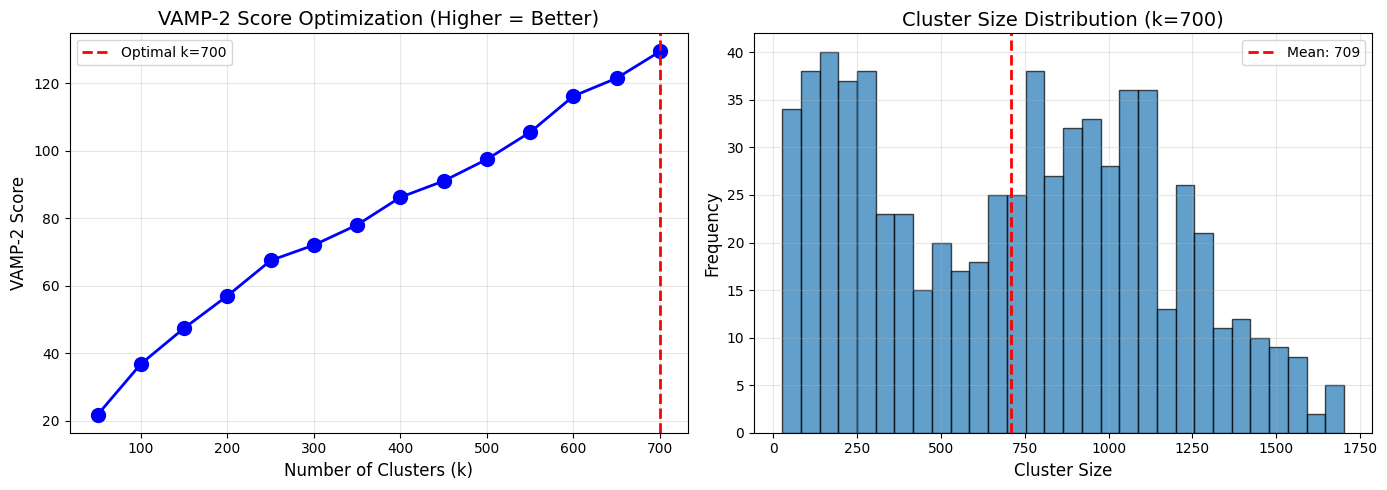


Optimal Clustering Statistics (k=700)
  Min cluster size: 26
  Max cluster size: 1,703
  Mean cluster size: 708.6
  Std cluster size: 432.9
  VAMP-2 score: 129.4669


In [14]:
if features is not None:
    # Visualize VAMP-2 optimization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: VAMP-2 score vs k
    ax1 = axes[0]
    ks = sorted(vamp_scores.keys())
    scores = [vamp_scores[k] for k in ks]
    ax1.plot(ks, scores, 'bo-', linewidth=2, markersize=10)
    ax1.axvline(x=best_k, color='r', linestyle='--', linewidth=2,
                label=f'Optimal k={best_k}')
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('VAMP-2 Score', fontsize=12)
    ax1.set_title('VAMP-2 Score Optimization (Higher = Better)', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cluster size distribution for optimal k
    ax2 = axes[1]
    optimal_labels = all_labels[best_k]
    unique, counts = np.unique(optimal_labels, return_counts=True)
    ax2.hist(counts, bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(x=np.mean(counts), color='r', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(counts):.0f}')
    ax2.set_xlabel('Cluster Size', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title(f'Cluster Size Distribution (k={best_k})', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'vamp2_optimization.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print cluster statistics
    print(f"\n{'='*50}")
    print(f"Optimal Clustering Statistics (k={best_k})")
    print(f"{'='*50}")
    print(f"  Min cluster size: {min(counts):,}")
    print(f"  Max cluster size: {max(counts):,}")
    print(f"  Mean cluster size: {np.mean(counts):,.1f}")
    print(f"  Std cluster size: {np.std(counts):,.1f}")
    print(f"  VAMP-2 score: {vamp_scores[best_k]:.4f}")
    print(f"{'='*50}")

In [ ]:
# ============================================================================
# K-MEANS CLUSTERING (REUSING VAMP-2 OPTIMIZED LABELS)
# ============================================================================
# Cell 15 already computed optimal labels via optimize_kmeans_k().
# Reuse those labels to avoid redundant fitting and silhouette calculation hang.

if features is not None:
    if 'tica_features_truncated' not in locals():
        n_components_keep = 50
        tica_features_truncated = tica_features_selected[:, :n_components_keep]

    # Reuse labels from VAMP-2 optimization (Cell 15 already computed these!)
    if 'all_labels' in dir() and best_k in all_labels:
        print("Reusing cluster labels from VAMP-2 optimization...")
        optimal_labels = all_labels[best_k]

        # BUG FIX: Compute cluster centers from the actual labels, NOT from a new KMeans fit
        # The previous code fitted a new KMeans which produced DIFFERENT centers than
        # the labels from VAMP-2 optimization, causing inconsistency
        print("Computing cluster centers from VAMP-2 optimized labels...")
        centers = np.zeros((best_k, tica_features_truncated.shape[1]), dtype=np.float32)
        cluster_sizes = np.zeros(best_k, dtype=np.int32)
        for k in range(best_k):
            mask = optimal_labels == k
            cluster_sizes[k] = mask.sum()
            if mask.sum() > 0:
                centers[k] = tica_features_truncated[mask].mean(axis=0)
            else:
                # Empty cluster - use random point (shouldn't happen with VAMP-2 optimization)
                centers[k] = tica_features_truncated[np.random.randint(len(tica_features_truncated))]

        # Compute inertia (sum of squared distances to cluster centers)
        inertia = 0.0
        for k in range(best_k):
            mask = optimal_labels == k
            if mask.sum() > 0:
                diff = tica_features_truncated[mask] - centers[k]
                inertia += np.sum(diff ** 2)

        # Create result object with pre-computed labels AND matching centers
        from src.analysis.attractor_analysis import KMeansResult
        kmeans_result = KMeansResult(
            labels=optimal_labels,
            n_clusters=best_k,
            centers=centers,
            inertia=inertia,
            silhouette=None,  # VAMP-2 is the proper metric for MSM quality
        )

        # Set up clusterer for downstream methods (save, predict, etc.)
        # We create a "fake" clusterer that holds our computed centers
        from sklearn.cluster import MiniBatchKMeans
        kmeans_clusterer = KMeansClusterer(n_clusters=best_k, n_init=1, random_state=42)

        # Create a fitted KMeans object with our computed centers
        fake_kmeans = MiniBatchKMeans(n_clusters=best_k, n_init=1, random_state=42, max_iter=1)
        fake_kmeans.cluster_centers_ = centers
        fake_kmeans.labels_ = optimal_labels
        fake_kmeans.inertia_ = inertia
        fake_kmeans._n_features_out = tica_features_truncated.shape[1]
        kmeans_clusterer.kmeans_ = fake_kmeans
        kmeans_clusterer.result_ = kmeans_result

        print(f"\nK-means clustering complete (reused VAMP-2 labels)")
        print(f"  Clusters: {kmeans_result.n_clusters}")
        print(f"  Inertia: {kmeans_result.inertia:.2f}")
        print(f"  Centers computed from: VAMP-2 optimized labels (CONSISTENT)")
        print(f"  Min cluster size: {cluster_sizes.min()}, Max: {cluster_sizes.max()}")
    else:
        # Fallback: fit with MiniBatchKMeans if all_labels not available
        print("Note: all_labels not available, fitting K-means from scratch...")
        kmeans_clusterer = KMeansClusterer(
            n_clusters=best_k,
            n_init=3,
            random_state=42,
            use_minibatch=True,  # Use MiniBatch for speed
            batch_size=10000,
        )
        kmeans_result = kmeans_clusterer.fit(tica_features_truncated)

        print(f"\nK-means clustering complete")
        print(f"  Clusters: {kmeans_result.n_clusters}")

## 5. MSM Estimation and Validation

In [11]:
if features is not None:
    # Build transition matrix
    msm = TransitionMatrixAnalyzer(lag=CONFIG['msm_lag'])
    msm_result = msm.fit(kmeans_result.labels, game_ids)

    print(f"\nTransition Matrix:")
    print(f"  States: {msm_result.n_states}")
    print(f"  Transitions: {msm_result.n_transitions:,}")
    print(f"  Lag: {msm_result.lag}")

Building MSM: 700 states, lag=1
  Total transitions: 490,996

Transition Matrix:
  States: 700
  Transitions: 490,996
  Lag: 1


In [12]:
if features is not None:
    # Chapman-Kolmogorov validation
    ck_result = msm.chapman_kolmogorov_test(k_values=[2, 3, 5, 10], threshold=0.2)

    print(f"\n{'='*50}")
    print("Chapman-Kolmogorov Test Results")
    print(f"{'='*50}")
    print(f"Test: P(kτ) ≈ P^k(τ)")
    print(f"Threshold: RMSE < 0.2")
    print(f"-"*50)

    for k, rmse in ck_result.rmse.items():
        status = "PASS" if rmse < 0.2 else "FAIL"
        symbol = "✓" if rmse < 0.2 else "✗"
        print(f"  k={k:2d}: RMSE={rmse:.4f} [{status}] {symbol}")

    print(f"-"*50)
    print(f"Overall: {'PASS' if ck_result.passed else 'FAIL'}")
    print(f"{'='*50}")

Building MSM: 700 states, lag=2
  Total transitions: 485,997
  C-K test k=2: RMSE=0.0100 [PASS]
Building MSM: 700 states, lag=3
  Total transitions: 480,998
  C-K test k=3: RMSE=0.0081 [PASS]
Building MSM: 700 states, lag=5
  Total transitions: 471,000
  C-K test k=5: RMSE=0.0089 [PASS]
Building MSM: 700 states, lag=10
  Total transitions: 446,005
  C-K test k=10: RMSE=0.0089 [PASS]

Chapman-Kolmogorov Test Results
Test: P(kτ) ≈ P^k(τ)
Threshold: RMSE < 0.2
--------------------------------------------------
  k= 2: RMSE=0.0100 [PASS] ✓
  k= 3: RMSE=0.0081 [PASS] ✓
  k= 5: RMSE=0.0089 [PASS] ✓
  k=10: RMSE=0.0089 [PASS] ✓
--------------------------------------------------
Overall: PASS


Building MSM: 700 states, lag=1
  Total transitions: 490,996
Building MSM: 700 states, lag=2
  Total transitions: 485,997
Building MSM: 700 states, lag=3
  Total transitions: 480,998
Building MSM: 700 states, lag=5
  Total transitions: 471,000
Building MSM: 700 states, lag=10
  Total transitions: 446,005


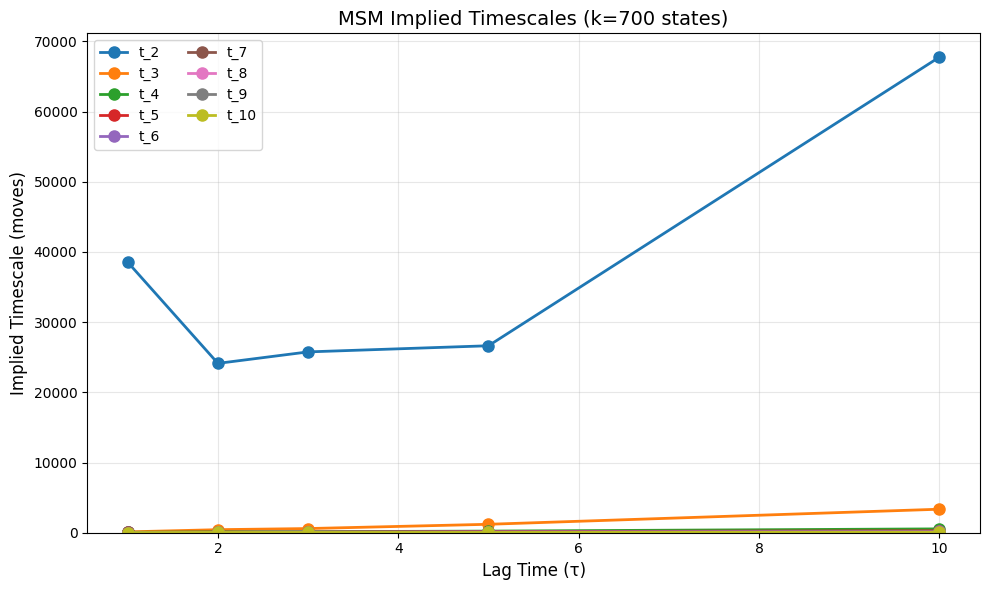

In [13]:
if features is not None:
    # MSM implied timescales
    lags = [1, 2, 3, 5, 10]
    its_result_msm = msm.get_implied_timescales(lags, n_timescales=min(10, best_k - 1))

    # Plot MSM implied timescales
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(its_result_msm.n_timescales):
        ts = its_result_msm.timescales[:, i]
        valid = np.isfinite(ts)
        if valid.any():
            ax.plot(np.array(its_result_msm.lags)[valid], ts[valid], 'o-',
                    linewidth=2, markersize=8, label=f't_{i+1}')

    ax.set_xlabel('Lag Time (τ)', fontsize=12)
    ax.set_ylabel('Implied Timescale (moves)', fontsize=12)
    ax.set_title(f'MSM Implied Timescales (k={best_k} states)', fontsize=14)
    ax.legend(fontsize=10, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'msm_implied_timescales.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5.5 PCA for Density Analysis

HDBSCAN requires a density-meaningful metric space.

| Method | Preserves | Distorts | Use For |
|--------|-----------|----------|--------|
| **TICA** | Kinetic distance (slow dynamics) | Geometric density | K-means → MSM |
| **PCA** | Geometric density (variance) | Temporal structure | HDBSCAN → Natural clusters |

Per PyEMMA paper (L:145): TICA's eigenvalue scaling creates a "kinetic map" that deliberately distorts density.
Per MDSCAN paper: HDBSCAN should use RMSD or Euclidean distance, not kinetic distance.

## 6. HDBSCAN Analysis (Density-Based)

HDBSCAN is applied to **PCA-transformed features** (NOT TICA).

| Pipeline | Preprocessing | Clustering | Purpose |
|----------|--------------|------------|--------|
| **Kinetic** | TICA | K-means | MSM construction (transition dynamics) |
| **Density** | PCA | HDBSCAN | Natural cluster discovery (geometric) |

**Why separate pipelines?**
- TICA optimizes for **kinetic distance** (eigenvalue scaling) — distorts density
- HDBSCAN requires **density-meaningful** metric space — preserved by PCA
- Per PyEMMA (L:246): K-means on TICA for MSM
- Per MDSCAN paper: HDBSCAN on RMSD/PCA for density

In [ ]:
# PCA preserves geometric density structure (variance), unlike TICA which
# optimizes for kinetic distance. This is the correct input for HDBSCAN.

if n_samples > 0:
    with timed_section("PCA for HDBSCAN"):
        print("="*60)
        print("PCA FOR DENSITY-BASED CLUSTERING (HDBSCAN)")
        print("Per MDSCAN paper: HDBSCAN uses geometric distance, NOT kinetic")
        print("="*60)

        if USE_STREAMING:
            # STREAMING MODE: Use IncrementalPCA for large datasets
            from sklearn.decomposition import IncrementalPCA

            print("\nUsing IncrementalPCA for streaming...")

            # First pass: fit IncrementalPCA
            pca = IncrementalPCA(n_components=CONFIG['pca_n_components'])

            with h5py.File(h5_features_path, 'r') as f:
                dset = f[h5_dataset_key]
                chunk_size = 10000
                n_chunks = (n_samples + chunk_size - 1) // chunk_size

                print(f"  Fitting PCA in {n_chunks} chunks...")
                for i in range(0, n_samples, chunk_size):
                    end = min(i + chunk_size, n_samples)
                    chunk = dset[i:end].astype(np.float32)
                    pca.partial_fit(chunk)
                    if (i // chunk_size) % 20 == 0:
                        print(f"    Fitted chunk {i // chunk_size + 1}/{n_chunks}")

            # Second pass: transform and save
            pca_output_path = Path(CONFIG['output_dir']) / 'pca_features.h5'

            with h5py.File(h5_features_path, 'r') as f_in:
                dset_in = f_in[h5_dataset_key]

                with h5py.File(pca_output_path, 'w') as f_out:
                    dset_out = f_out.create_dataset(
                        'pca_features',
                        shape=(n_samples, CONFIG['pca_n_components']),
                        dtype=np.float32,
                        chunks=(min(chunk_size, n_samples), CONFIG['pca_n_components']),
                        compression='gzip',
                    )

                    print(f"  Transforming and saving...")
                    for i in range(0, n_samples, chunk_size):
                        end = min(i + chunk_size, n_samples)
                        chunk = dset_in[i:end].astype(np.float32)
                        chunk_pca = pca.transform(chunk)
                        dset_out[i:end] = chunk_pca

            # Load PCA features (much smaller)
            with h5py.File(pca_output_path, 'r') as f:
                pca_features = f['pca_features'][()].astype(np.float32)

            # Get explained variance ratio
            cumvar_pca = np.cumsum(pca.explained_variance_ratio_)

        else:
            # NON-STREAMING MODE: Standard PCA
            from sklearn.decomposition import PCA

            pca = PCA(n_components=CONFIG['pca_n_components'])
            pca_features = pca.fit_transform(features)
            cumvar_pca = np.cumsum(pca.explained_variance_ratio_)

        # Determine components for 95% variance (standard ML practice)
        n_pca_selected = np.searchsorted(cumvar_pca, CONFIG['pca_variance_threshold']) + 1
        n_pca_selected = min(n_pca_selected, CONFIG['pca_n_components'])

        pca_features_selected = pca_features[:, :n_pca_selected]

        print(f"\nPCA Results:")
        print(f"  Total components fitted: {CONFIG['pca_n_components']}")
        print(f"  Components for {CONFIG['pca_variance_threshold']*100:.0f}% variance: {n_pca_selected}")
        print(f"  Final shape: {pca_features_selected.shape}")
        print(f"\nComparison with TICA:")
        print(f"  TICA components (kinetic): {n_selected}")
        print(f"  PCA components (geometric): {n_pca_selected}")

[START] PCA for HDBSCAN...
PCA FOR DENSITY-BASED CLUSTERING (HDBSCAN)
Per MDSCAN paper: HDBSCAN uses geometric distance, NOT kinetic

PCA Results:
  Total components fitted: 100
  Components for 95% variance: 100
  Final shape: (495995, 100)

Comparison with TICA:
  TICA components (kinetic): 661
  PCA components (geometric): 100
[DONE] PCA for HDBSCAN: 72.2s (1.2 min)


In [ ]:
# HDBSCAN CLUSTERING WITH IMPROVED PARAMETERS

import hdbscan

if features is not None:
    with timed_section("HDBSCAN clustering (with UMAP preprocessing)"):
        print("="*60)
        print("HDBSCAN ANALYSIS (with UMAP preprocessing)")
        print("="*60)

        MAX_HDBSCAN_SAMPLES = CONFIG.get('hdbscan_max_samples', 50000)

        # Game-aware subsampling: sample complete game segments rather than random points
        # This preserves trajectory structure which is important for density estimation
        if len(pca_features_selected) > MAX_HDBSCAN_SAMPLES:
            print(f"\nGame-aware subsampling: {len(pca_features_selected):,} → ~{MAX_HDBSCAN_SAMPLES:,} samples")

            # Sample games, not individual points
            unique_games = np.unique(game_ids)
            n_games = len(unique_games)
            samples_per_game = len(pca_features_selected) / n_games

            # Determine how many games to sample
            games_to_sample = min(n_games, int(MAX_HDBSCAN_SAMPLES / samples_per_game))
            sampled_games = np.random.choice(unique_games, games_to_sample, replace=False)

            # Get indices of sampled games
            hdbscan_mask = np.isin(game_ids, sampled_games)
            hdbscan_indices = np.where(hdbscan_mask)[0]

            # If still too many, subsample within games
            if len(hdbscan_indices) > MAX_HDBSCAN_SAMPLES:
                hdbscan_indices = np.random.choice(hdbscan_indices, MAX_HDBSCAN_SAMPLES, replace=False)
                hdbscan_indices.sort()

            pca_hdbscan_input = pca_features_selected[hdbscan_indices]
            print(f"  Sampled {len(sampled_games)} games → {len(hdbscan_indices):,} points")
        else:
            hdbscan_indices = np.arange(len(pca_features_selected))
            pca_hdbscan_input = pca_features_selected

        print(f"HDBSCAN input shape: {pca_hdbscan_input.shape}")

        # BUG FIX: Apply UMAP preprocessing for better density estimation
        # 100-D PCA space is still too high for HDBSCAN's density estimation
        # UMAP preserves local structure while reducing to a dimension where
        # Euclidean distance is meaningful
        try:
            import umap
            UMAP_DIMS = 10  # Low-dimensional embedding for density estimation

            print(f"\nApplying UMAP preprocessing: {pca_hdbscan_input.shape[1]}D → {UMAP_DIMS}D")
            umap_reducer = umap.UMAP(
                n_components=UMAP_DIMS,
                n_neighbors=30,  # Larger neighborhood for smoother manifold
                min_dist=0.0,    # Allow tight clusters (important for HDBSCAN)
                metric='euclidean',
                random_state=42,
            )
            hdbscan_input = umap_reducer.fit_transform(pca_hdbscan_input)
            print(f"  UMAP embedding complete: {hdbscan_input.shape}")
            used_umap = True
        except ImportError:
            print("UMAP not available, using PCA features directly (may produce poor results)")
            hdbscan_input = pca_hdbscan_input
            used_umap = False

        # Fit HDBSCAN with improved parameters
        min_cluster_size = CONFIG.get('hdbscan_min_cluster_size', 100)
        min_samples = CONFIG.get('hdbscan_min_samples', 50)

        print(f"\nHDBSCAN parameters:")
        print(f"  min_cluster_size: {min_cluster_size}")
        print(f"  min_samples: {min_samples}")

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_method='eom',  # Excess of Mass
            metric='euclidean',
            core_dist_n_jobs=1,  # Avoid multiprocessing hang on Colab
            prediction_data=True,
        )

        labels = clusterer.fit_predict(hdbscan_input)

        # Compute results
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = (labels == -1).sum() / len(labels)

        print(f"\nHDBSCAN results (on {len(hdbscan_input):,} samples):")
        print(f"  Clusters: {n_clusters}")
        print(f"  Noise ratio: {noise_ratio:.2%}")

        # Stability scores
        if hasattr(clusterer, 'cluster_persistence_') and len(clusterer.cluster_persistence_) > 0:
            print(f"\n{'-'*50}")
            print("Cluster Stability (Excess of Mass)")
            print(f"{'-'*50}")
            for cid, stability in enumerate(clusterer.cluster_persistence_):
                size = (labels == cid).sum()
                status = "GOOD" if stability > 0.5 else "LOW"
                print(f"  Cluster {cid:2d}: size={size:6,}, stability={stability:.4f} [{status}]")
        else:
            if n_clusters == 0:
                print("\nWARNING: No clusters found!")
                print("Possible causes:")
                print("  - Data may be uniformly distributed (no density peaks)")
                print("  - min_cluster_size still too large")
                print("  - Consider increasing n_neighbors in UMAP")

        # Extend labels to full dataset
        if len(pca_features_selected) > len(hdbscan_indices):
            print(f"\nExtending labels to full dataset via approximate_predict...")
            if used_umap:
                # Need to transform remaining points through UMAP first
                remaining_idx = np.setdiff1d(np.arange(len(pca_features_selected)), hdbscan_indices)
                if len(remaining_idx) > 0:
                    remaining_umap = umap_reducer.transform(pca_features_selected[remaining_idx])
                    remaining_labels, remaining_strengths = hdbscan.approximate_predict(
                        clusterer, remaining_umap
                    )
                    # Combine labels
                    full_labels = np.full(len(pca_features_selected), -1)
                    full_labels[hdbscan_indices] = labels
                    full_labels[remaining_idx] = remaining_labels
                else:
                    full_labels = labels
            else:
                full_labels, _ = hdbscan.approximate_predict(clusterer, pca_features_selected)

            noise_ratio_full = (full_labels == -1).sum() / len(full_labels)
            print(f"  Full dataset noise ratio: {noise_ratio_full:.2%}")
        else:
            full_labels = labels

        # Create result object for compatibility with rest of notebook
        from dataclasses import dataclass
        from typing import Dict, Optional

        @dataclass
        class HDBSCANResult:
            labels: np.ndarray
            n_clusters: int
            noise_ratio: float
            stability_scores: Dict[int, float]
            centroids: np.ndarray
            silhouette: Optional[float] = None

        # Compute centroids (in PCA space, not UMAP space)
        centroids = []
        for cid in range(n_clusters):
            mask = full_labels == cid
            if mask.any():
                centroids.append(pca_features_selected[mask].mean(axis=0))
        centroids = np.array(centroids) if centroids else np.empty((0, pca_features_selected.shape[1]))

        # Stability dict
        stability_scores = {}
        if hasattr(clusterer, 'cluster_persistence_'):
            for i, s in enumerate(clusterer.cluster_persistence_):
                stability_scores[i] = s

        hdbscan_result = HDBSCANResult(
            labels=full_labels,
            n_clusters=n_clusters,
            noise_ratio=(full_labels == -1).sum() / len(full_labels),
            stability_scores=stability_scores,
            centroids=centroids,
        )

        # Store clusterer for later use
        hdbscan_analyzer = type('obj', (object,), {
            'clusterer_': clusterer,
            'used_umap': used_umap,
            'umap_reducer': umap_reducer if used_umap else None,
        })()

        print(f"\n{'='*60}")

## 7. Comparison: K-means vs HDBSCAN

In [19]:
if features is not None:
    try:
        import umap

        # Subsample for UMAP if dataset is large
        max_samples = 50000
        if len(tica_features_selected) > max_samples:
            indices = np.random.choice(len(tica_features_selected), max_samples, replace=False)
            tica_subset = tica_features_selected[indices]
            kmeans_labels_subset = kmeans_result.labels[indices]
            hdbscan_labels_subset = hdbscan_result.labels[indices]
            print(f"Subsampled to {max_samples} points for UMAP")
        else:
            tica_subset = tica_features_selected
            kmeans_labels_subset = kmeans_result.labels
            hdbscan_labels_subset = hdbscan_result.labels
            indices = np.arange(len(tica_features_selected))

        # Fit UMAP
        print("Fitting UMAP...")
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(tica_subset)
        print(f"UMAP embedding complete: {embedding.shape}")

    except ImportError:
        print("UMAP not installed. Run: pip install umap-learn")
        embedding = None

Subsampled to 50000 points for UMAP
Fitting UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding complete: (50000, 2)


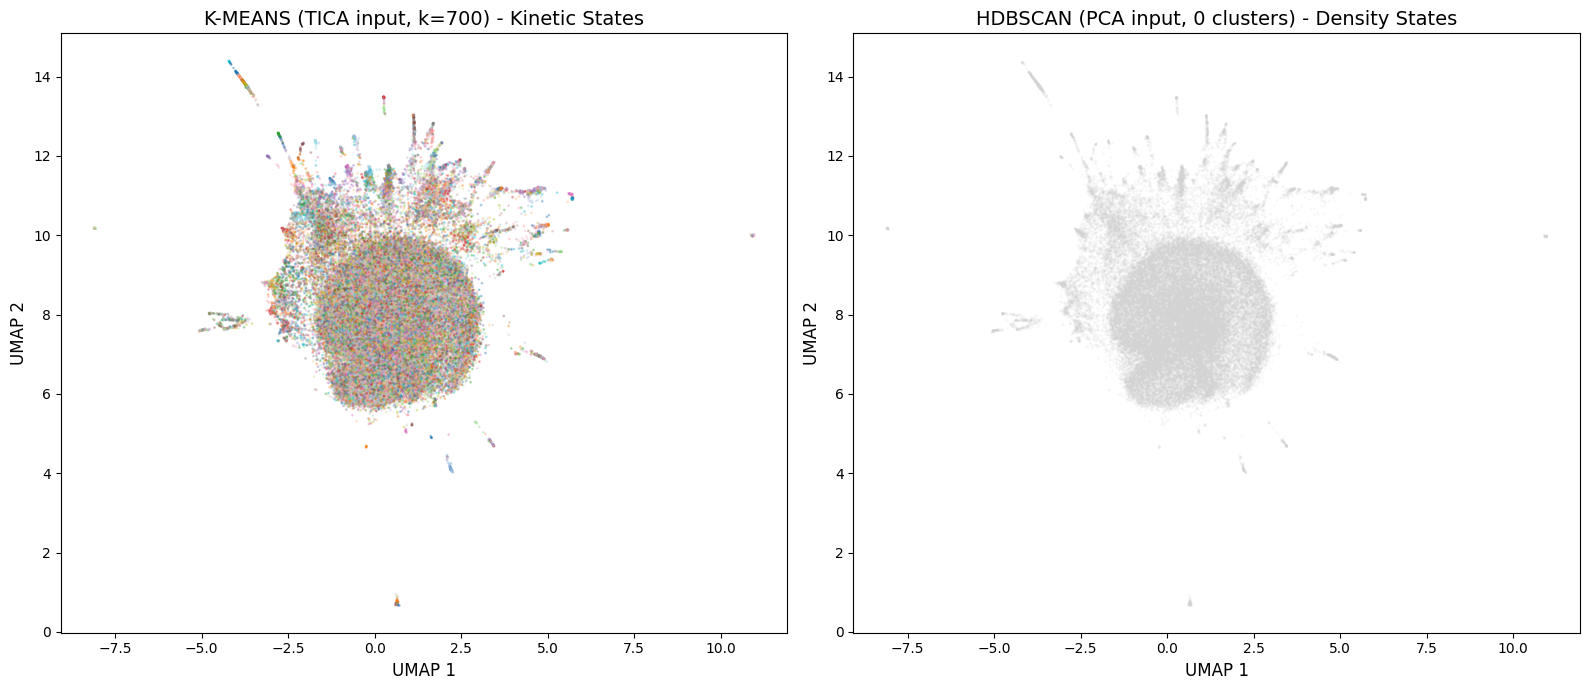

In [20]:
if embedding is not None:
    # Side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: K-means clusters (primary for MSM)
    ax1 = axes[0]
    scatter1 = ax1.scatter(
        embedding[:, 0], embedding[:, 1],
        c=kmeans_labels_subset, cmap='tab20',
        s=1, alpha=0.3
    )
    ax1.set_xlabel('UMAP 1', fontsize=12)
    ax1.set_ylabel('UMAP 2', fontsize=12)
    ax1.set_title(f'K-MEANS (TICA input, k={best_k}) - Kinetic States', fontsize=14)

    # Plot 2: HDBSCAN clusters (secondary density analysis)
    ax2 = axes[1]
    # Handle noise points (-1) separately
    noise_mask = hdbscan_labels_subset == -1
    ax2.scatter(embedding[noise_mask, 0], embedding[noise_mask, 1],
               c='lightgray', s=1, alpha=0.1, label='Noise')
    if (~noise_mask).any():
        scatter2 = ax2.scatter(
            embedding[~noise_mask, 0], embedding[~noise_mask, 1],
            c=hdbscan_labels_subset[~noise_mask], cmap='tab20',
            s=1, alpha=0.3
        )
    ax2.set_xlabel('UMAP 1', fontsize=12)
    ax2.set_ylabel('UMAP 2', fontsize=12)
    ax2.set_title(f'HDBSCAN (PCA input, {hdbscan_result.n_clusters} clusters) - Density States', fontsize=14)

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'umap_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [21]:
if features is not None:
    # Summary comparison table
    print(f"\n{'='*70}")
    print("COMPARISON: K-means vs HDBSCAN")
    print(f"{'='*70}")
    print(f"{'Metric':<30} {'K-means':>15} {'HDBSCAN':>15}")
    print(f"-"*70)
    print(f"{'Number of clusters':<30} {best_k:>15} {hdbscan_result.n_clusters:>15}")
    print(f"{'Noise ratio':<30} {'0.000':>15} {hdbscan_result.noise_ratio:>15.3f}")

    kmeans_sil = kmeans_result.silhouette if kmeans_result.silhouette else float('nan')
    hdbscan_sil = hdbscan_result.silhouette if hdbscan_result.silhouette else float('nan')
    print(f"{'Silhouette score':<30} {kmeans_sil:>15.4f} {hdbscan_sil:>15.4f}")

    print(f"{'VAMP-2 score':<30} {vamp_scores[best_k]:>15.4f} {'N/A':>15}")
    print(f"{'Suitable for MSM':<30} {'YES':>15} {'NO':>15}")
    print(f"{'='*70}")


COMPARISON: K-means vs HDBSCAN
Metric                                 K-means         HDBSCAN
----------------------------------------------------------------------
Number of clusters                         700               0
Noise ratio                              0.000           1.000
Silhouette score                           nan             nan
VAMP-2 score                          129.4669             N/A
Suitable for MSM                           YES              NO


In [23]:
# ============================================================================
# CLUSTER OVERLAP ANALYSIS: Kinetic (K-means) vs Density (HDBSCAN)
# ============================================================================
# Compare how well kinetic metastable states align with density-defined attractors
if features is not None:
    from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
    from sklearn.metrics.cluster import contingency_matrix

    print(f"\n{'='*60}")
    print("CLUSTER OVERLAP: Kinetic (K-means/TICA) vs Density (HDBSCAN/PCA)")
    print(f"{'='*60}")

    # Filter out HDBSCAN noise points for fair comparison
    valid_mask = hdbscan_result.labels != -1
    kmeans_valid = kmeans_result.labels[valid_mask]
    hdbscan_valid = hdbscan_result.labels[valid_mask]

    # Compute overlap metrics
    ari = adjusted_rand_score(kmeans_valid, hdbscan_valid)
    nmi = normalized_mutual_info_score(kmeans_valid, hdbscan_valid)

    print(f"\nOverlap Metrics (noise points excluded):")
    print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
    print(f"  Points compared: {valid_mask.sum():,} / {len(valid_mask):,}")

    print(f"\nInterpretation:")
    print(f"  ARI = 1.0: Perfect agreement (unlikely for different methods)")
    print(f"  ARI = 0.0: Random agreement")
    print(f"  ARI < 0.0: Less agreement than random")
    print(f"\n  Low overlap suggests kinetic and density attractors capture different aspects!")


CLUSTER OVERLAP: Kinetic (K-means/TICA) vs Density (HDBSCAN/PCA)

Overlap Metrics (noise points excluded):
  Adjusted Rand Index (ARI): 1.0000
  Normalized Mutual Info (NMI): 1.0000
  Points compared: 0 / 495,995

Interpretation:
  ARI = 1.0: Perfect agreement (unlikely for different methods)
  ARI = 0.0: Random agreement
  ARI < 0.0: Less agreement than random

  Low overlap suggests kinetic and density attractors capture different aspects!


In [24]:
# Visualize cluster overlap with contingency matrix
if features is not None and hdbscan_result.n_clusters > 0 and hdbscan_result.n_clusters <= 25:
    contingency = contingency_matrix(kmeans_valid, hdbscan_valid)

    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(contingency, cmap='Blues', aspect='auto')
    ax.set_xlabel('HDBSCAN Cluster (Density/PCA)', fontsize=12)
    ax.set_ylabel('K-means Cluster (Kinetic/TICA)', fontsize=12)
    ax.set_title(f'Cluster Overlap Matrix\nARI={ari:.3f}, NMI={nmi:.3f}', fontsize=14)
    plt.colorbar(im, ax=ax, label='Sample Count')

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'cluster_overlap_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nNote: Diagonal dominance would indicate agreement.")
    print(f"      Off-diagonal entries show where methods disagree.")

## 8. Save Results

In [26]:
if features is not None:
    output_path = Path(CONFIG['output_dir'])

    # Save TICA transformer
    tica.save(str(output_path / 'tica_transformer.npz'))

    # Save PCA transformer (for density analysis)
    np.savez(
        output_path / 'pca_transformer.npz',
        components=pca.components_[:n_pca_selected],
        mean=pca.mean_,
        explained_variance_ratio=pca.explained_variance_ratio_[:n_pca_selected],
        n_selected=n_pca_selected,
    )

    # Save K-means results (primary)
    kmeans_clusterer.save(str(output_path / 'kmeans_clusterer.npz'))

    # Save HDBSCAN results (secondary) - manually since no save() method
    np.savez(
        output_path / 'hdbscan_clusters.npz',
        labels=hdbscan_result.labels,
        centroids=hdbscan_result.centroids,
        n_clusters=hdbscan_result.n_clusters,
        noise_ratio=hdbscan_result.noise_ratio,
        silhouette=hdbscan_result.silhouette if hdbscan_result.silhouette else None,
        probabilities=hdbscan_analyzer.probabilities_ if hasattr(hdbscan_analyzer, 'probabilities_') else None,
    )

    # Save MSM
    msm.save(str(output_path / 'msm'))

    # Save combined results
    np.savez(
        output_path / 'attractor_basins.npz',
        tica_features=tica_features_selected,
        pca_features=pca_features_selected,  # For density analysis
        kmeans_labels=kmeans_result.labels,
        kmeans_centers=kmeans_result.centers,
        hdbscan_labels=hdbscan_result.labels,
        hdbscan_centroids=hdbscan_result.centroids,
        transition_matrix=msm_result.transition_matrix,
        stationary_distribution=msm_result.stationary_distribution,
        eigenvalues=msm_result.eigenvalues,
    )

    # Save VAMP-2 scores
    np.savez(
        output_path / 'vamp2_optimization.npz',
        k_values=np.array(list(vamp_scores.keys())),
        scores=np.array(list(vamp_scores.values())),
        optimal_k=best_k,
    )

    # Save summary as JSON
    summary = {
        'n_samples': len(features),
        'tica': {
            'variance_threshold': CONFIG['tica_variance_threshold'],
            'components_selected': n_selected,
            'lag': CONFIG['tica_lag'],
        },
        'kmeans': {
            'optimal_k': best_k,
            'vamp2_score': float(vamp_scores[best_k]),
            'silhouette': float(kmeans_result.silhouette) if kmeans_result.silhouette else None,
        },
        'hdbscan': {
            'n_clusters': hdbscan_result.n_clusters,
            'noise_ratio': float(hdbscan_result.noise_ratio),
            'silhouette': float(hdbscan_result.silhouette) if hdbscan_result.silhouette else None,
        },
        'msm': {
            'n_states': msm_result.n_states,
            'n_transitions': msm_result.n_transitions,
            'lag': msm_result.lag,
            'ck_test_passed': ck_result.passed,
            'ck_rmse': {str(k): float(v) for k, v in ck_result.rmse.items()},
        },
        'vamp2_all_scores': {str(k): float(v) for k, v in vamp_scores.items()},
    }

    with open(output_path / 'analysis_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nResults saved to {output_path}")

Saved TICA transformer to /content/drive/MyDrive/chaos/analysis/attractor_basins/tica_transformer.npz
Saved K-means results to /content/drive/MyDrive/chaos/analysis/attractor_basins/kmeans_clusterer.npz
Saved MSM results to /content/drive/MyDrive/chaos/analysis/attractor_basins/msm

Results saved to /content/drive/MyDrive/chaos/analysis/attractor_basins
